# Data Acquisition

In [10]:
# https://medium.com/@yongsun.yoon/nba-face-recognition-system-345034ffed8c
import pandas as pd

roster = pd.read_html("https://basketball.realgm.com/nba/players")[4]
roster = roster.sort_values("Player")
roster = roster.head(50)
roster.head()

,#,Player,Pos,HT,WT,Age,Current Team,YOS,Pre-Draft Team,Draft Status,Nationality
166,20.0,A.J. Green,PG,6-4,190,24,Milwaukee Bucks,1,Northern Iowa,"2022 NBA Draft, Undrafted",United States
172,14.0,"A.J. Griffin, Jr.",SG,6-6,220,20,Atlanta Hawks,1,Duke,2022 Rnd 1 Pick 16,United States
261,9.0,A.J. Lawson,F,6-6,179,23,Dallas Mavericks,1,South Carolina,"2021 NBA Draft, Undrafted",Canada
162,50.0,Aaron Gordon,F,6-8,235,28,Denver Nuggets,9,Arizona,2014 Rnd 1 Pick 4,United States
200,0.0,Aaron Holiday,PG,6-0,185,27,Houston Rockets,5,UCLA,2018 Rnd 1 Pick 23,United States


In [18]:
import json
import requests
from tqdm import tqdm
import os
from config import SERPER_API_KEY

BASE_DIR = os.getcwd()
headers ={
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'
}

def search_image_urls(query, num_pages=3):
    url = "https://google.serper.dev/images"
    payload = json.dumps([{'q': query, 'page': p} for p in range(1, num_pages+1)])

    headers = {
        'X-API-KEY': SERPER_API_KEY,
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)
    response = json.loads(response.text)

    image_urls = [img["imageUrl"] for res in response for img in res["images"]]
    
    return image_urls, response


for i in tqdm(range(len(roster))):
    name = roster.iloc[i]['Player']
    player_dir = f'{BASE_DIR}/data/raw/{name}'
    # os.makedirs(player_dir, exist_ok=True)

    query = f'{name} NBA'
    # image_urls, response = search_image_urls(query)
    # for i, url in enumerate(image_urls):
    #     with open(os.path.join(player_dir, f"{i}.png"), "wb") as image_file:
    #         image_file.write(requests.get(url, headers=headers).content)

100%|██████████| 50/50 [24:46<00:00, 29.72s/it]


# Preparing Models

In [3]:
import insightface
from insightface.app.common import Face
from insightface.model_zoo import model_zoo
import cv2
import os
# MUST IMPORT TORCH FOR CUDA TO BE RECOGNISED
import torch

BASE_DIR = os.getcwd()

det_model_path = os.path.join(BASE_DIR, "../models", "buffalo_l", "det_10g.onnx")
rec_model_path = os.path.join(BASE_DIR, "../models", "buffalo_l", "w600k_r50.onnx")

det_model = model_zoo.get_model(det_model_path)
rec_model = model_zoo.get_model(rec_model_path)

det_model.prepare(ctx_id=0, input_size=(640, 640), det_thres=0.5)

# Embedding

In [ ]:
from glob import glob
import numpy as np
from tqdm import tqdm

known_names, unknown_names = [], []
known_embeddings, unknown_embeddings = [], []

players = os.listdir(f'{BASE_DIR}/data/raw')
for player in tqdm(players):
    player_embeddings, player_names = [], []

    img_paths = glob(f"{BASE_DIR}/data/raw/{player}/*")
    for img_path in img_paths:
        img = cv2.imread(img_path)
        if img is None: continue

        bboxes, kpss = det_model.detect(img, max_num=0, metric='defualt')
        if len(bboxes) != 1: continue

        bbox = bboxes[0, :4]
        det_score = bboxes[0, 4]
        kps = kpss[0]
        face = Face(bbox=bbox, kps=kps, det_score=det_score)

        rec_model.get(img, face)
        player_embeddings.append(face.normed_embedding)
        player_names.append(player)
        if len(player_embeddings) == 30: break
    
    player_embeddings = np.stack(player_embeddings, axis=0)
    h = 30//2
    known_embeddings.append(player_embeddings[0:h])
    unknown_embeddings.append(player_embeddings[h:])
    known_names += player_names[0:h]
    unknown_names += player_names[h:]

known_embeddings = np.concatenate(known_embeddings, axis=0)
unknown_embeddings = np.concatenate(unknown_embeddings, axis=0)

print(known_embeddings.shape)
print(unknown_embeddings.shape)
print(len(known_names))
print(len(unknown_names))

# Prediction

In [29]:
from collections import defaultdict

def search_flatten(known_embeddings, known_names, unknown_embeddings, threshold=0.5):
    pred_names = []
    for emb in unknown_embeddings:
        scores = np.dot(emb, known_embeddings.T)
        scores = np.clip(scores, 0., 1.)

        idx = np.argmax(scores)
        score = scores[idx]
        if score > threshold:
            pred_names.append(known_names[idx])
        else:
            pred_names.append(None)
    
    return pred_names

def get_averages(names, scores):
    d = defaultdict(list)
    for n, s in zip(names, scores):
        d[n].append(s)

    averages = {}
    for n, s in d.items():
        averages[n] = np.mean(s)
    
    return averages

def search_average(known_embeddings, known_names, unknown_embeddings, threshold=0.5):
    pred_names = []
    for emb in unknown_embeddings:
        scores = np.dot(emb, known_embeddings.T)
        scores = np.clip(scores, 0., 1.)

        averages = get_averages(known_names, scores)
        pred = sorted(averages, key=lambda x: averages[x], reverse=True)[0]
        score = averages[pred]

        if score > threshold:
            pred_names.append(pred)
        else:
            pred_names.append(None)
    
    return pred_names

# Evaluation

In [22]:
def evaluate(true_names, pred_names):
    coverage = np.mean([n is not None for n in pred_names]) * 100.

    is_corrects = []
    for t, p in zip(true_names, pred_names):
        if p is None: continue
        is_corrects.append(t == p)
    
    if not is_corrects:
        is_corrects.append(False)

    accuracy = np.mean(is_corrects) * 100.
    return accuracy, coverage

In [30]:
import pandas as pd

pred_names = search_flatten(known_embeddings, known_names, unknown_embeddings, threshold=0.45)
acc_flatten, cov_flatten = evaluate(unknown_names, pred_names)

pred_names = search_average(known_embeddings, known_names, unknown_embeddings, threshold=0.45)
acc_average, cov_average = evaluate(unknown_names, pred_names)

results = pd.DataFrame([
    {'method': 'flatten', 'accuracy': acc_flatten, 'coverage': cov_flatten},
    {'method': 'average', 'accuracy': acc_average, 'coverage': cov_average},
])

results

,method,accuracy,coverage
0,flatten,99.421965,98.295455
1,average,99.408284,96.022727


# Analysing Best Threshold

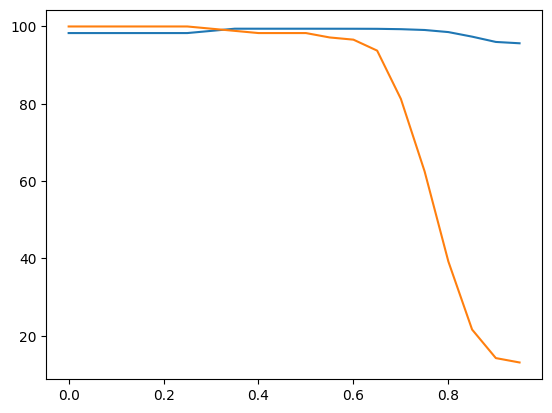

In [33]:
import matplotlib.pyplot as plt

thresholds = np.arange(0, 1, 0.05)
accuracies = []
coverages = []
for t in thresholds:
    # BEST PERFORMING IS FLATTEN
    pred_names = search_flatten(known_embeddings, known_names, unknown_embeddings, t)
    # pred_names = search_average(known_embeddings, known_names, unknown_embeddings, t)
    acc, cov = evaluate(unknown_names, pred_names)
    accuracies.append(acc)
    coverages.append(cov)

plt.plot(thresholds, accuracies)
plt.plot(thresholds, coverages)
plt.show()